In [1]:
import sys
sys.path.append('../')
from phonon_sonification import phonon_dos_sonifier

import matplotlib.pyplot as plt
from strauss.sonification import Sonification
from strauss.sources import Objects, Events
from strauss import channels
from strauss.score import Score
import numpy as np
from strauss.generator import Sampler
import IPython.display as ipd
import glob
import os
import copy
from pathlib import Path

In [2]:
sonifier = phonon_dos_sonifier.PhononDOSSonifier("mp-10378")

Fetching phonon DOS data for mp-10378...
There are 22 imaginary frequencies which have not been processed
  Phonon range (all sites): 1.91e+10 - 2.87e+12 Hz


In [3]:
site_name = 'Sb_1'
temperature = None

# Get site data
if site_name not in sonifier.dos_dict['projection']:
    available = list(sonifier.dos_dict['projection'].keys())
    raise ValueError(f"Site '{site_name}' not found. Available: {available}")

site_data = sonifier.dos_dict['projection'][site_name]
frequencies_hz = site_data['frequencies']
densities = site_data['densities']

# Get stats
if temperature is not None:
    if 'thermal' not in site_data['stats']:
        raise ValueError("No thermal data")
    if str(temperature) not in site_data['stats']['thermal']:
        raise ValueError(f"Temperature {temperature}K not found")
    stats = site_data['stats']['thermal'][str(temperature)]
    temp_label = f"{int(temperature)}K"
else:
    stats = site_data['stats']['athermal']
    temp_label = "athermal"

band_centre_hz = stats['band_centre']
q25_hz = stats['quantile_25']
q75_hz = stats['quantile_75']
iqr_hz = stats['IQR']

pitch_shift_semitones = sonifier.phonon_to_pitch_shift(band_centre_hz)

print(f"\nSonifying: {site_name} ({temp_label})")
print(f"  Band centre: {band_centre_hz:.2e} Hz → {pitch_shift_semitones:.1f} semitones")
print(f"  IQR: {iqr_hz:.2e} Hz")


Sonifying: Sb_1 (athermal)
  Band centre: 2.19e+12 Hz → 26.9 semitones
  IQR: 8.15e+11 Hz


In [2]:
baritone_sampler = Sampler("../data/samples/baritone_sax_sf/Baritone.sf2")
guitar_sampler = Sampler("../data/samples/soundfonts/guitars.sf2",sf_preset=49)
wav_sampler = Sampler("../data/samples/Solitary_Choir/Samples/")

In [7]:
baritone_sampler.preset_details()

default:
Default preset for the sampler, basic setup with no looping, and an on-off volume envelope.

staccato:
Forces a short volume envelope on each sample, such that a note is held for 30ms and fades out over 70ms, giving 100ms duration for each note to sound - works well to represent rapidly varying data using an Events source type.

sustain:
Sustain a sample indefinitely, achieved by holding the note on and using a loop between 0.2 and 0.5 seconds - works well to represent Object source types that vary over an extended period. This works best with extended samples or instruments that don't vary much, such as a violin or organ. Short samples (< 1s) or those that are quick or percussive (e.g. a piano) can lead to a regular variation in the sound that distracts from the data sonification. Tweaking loop_start and loop_end can help create a smoother sound for a given sample.



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.77it/s]


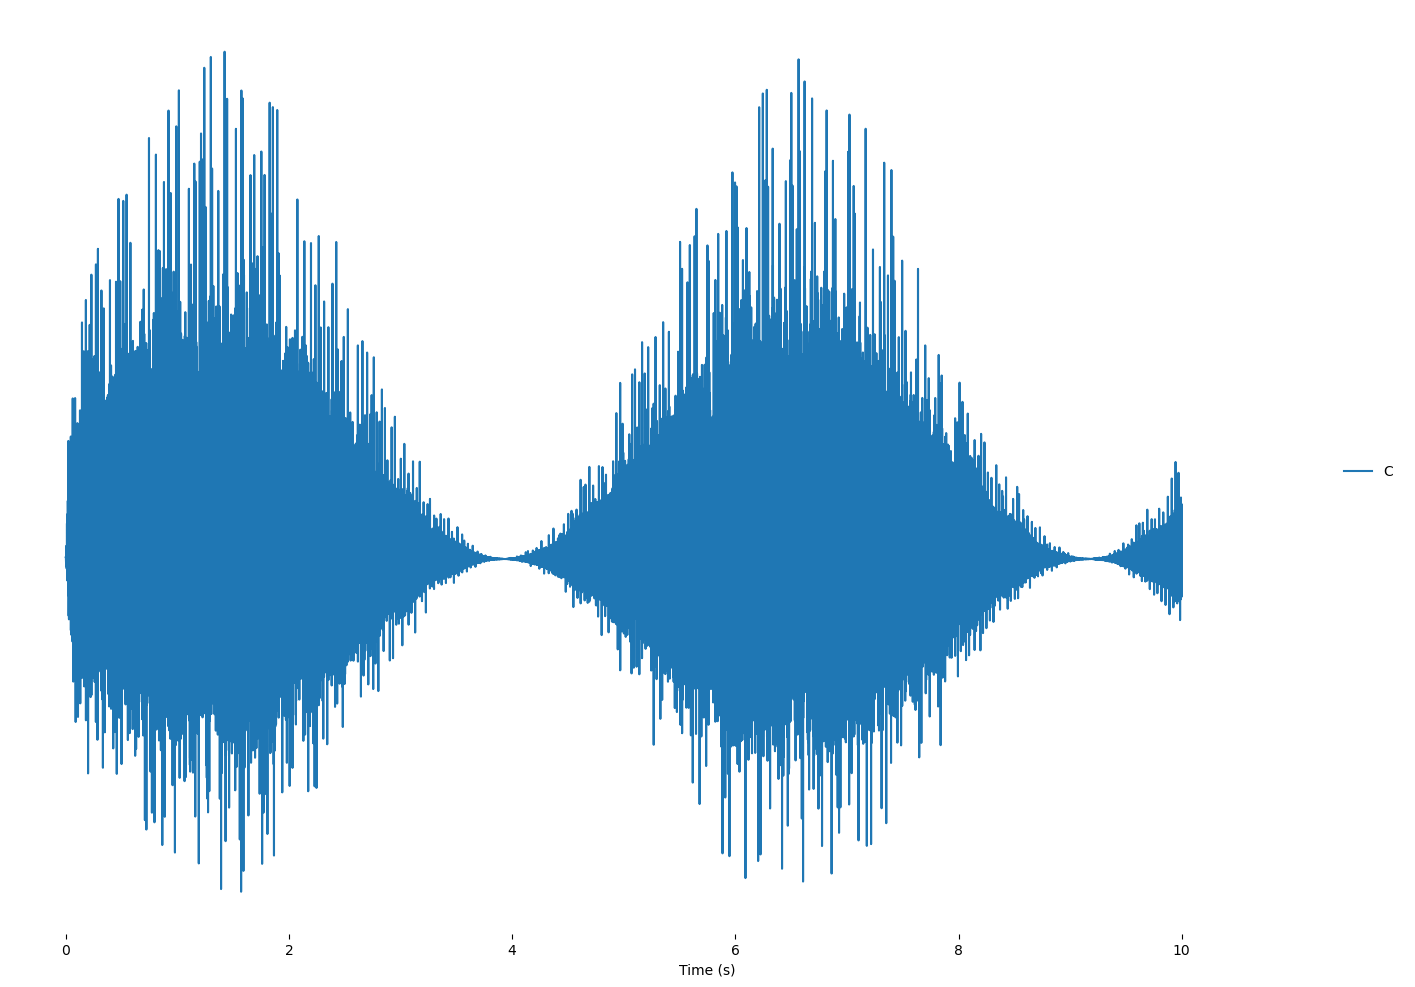

Text(0.5, 0, 'x')

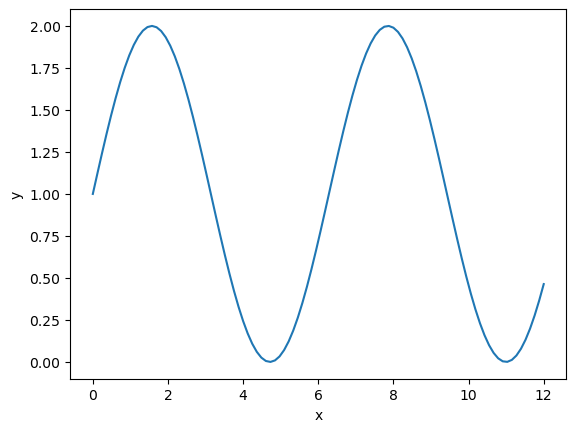

In [8]:
# sample data

x = np.linspace(0,12,100)
y = np.sin(np.linspace(0,12,100))+1

# pick a soundfont to use
system = "mono"

generator = copy.copy(baritone_sampler)
#generator = flute_sampler
#generator.modify_preset({'filter':'on'})
#generator.modify_preset({'looping':'forwardback',
 #                        'loop_start': 0.5, 'loop_end': 0.7}) #
generator.load_preset('sustain')

notes = [["A2","G3"]]
score =  Score(notes, 10)

data = {'pitch': [0.,0.],
        'time_evo': [x,x],
        'pitch_shift': [y,y],
     #   'cutoff': y,
        'volume':[y,y]}

mlims = {'time_evo':[0,12],
         'pitch_shift': [0,2],
    #     'cutoff': [0,2],
         'volume': [0,2]}

plims = {'pitch_shift': [0,24]}

# set up source
sources = Objects(data.keys())
sources.fromdict(data)
sources.apply_mapping_functions(map_lims=mlims, param_lims=plims)

soni = Sonification(score, sources, generator, system)
soni.render()
dobj = soni.notebook_display(show_waveform=1);
plt.plot(x,y)
plt.ylabel('y')
plt.xlabel('x')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


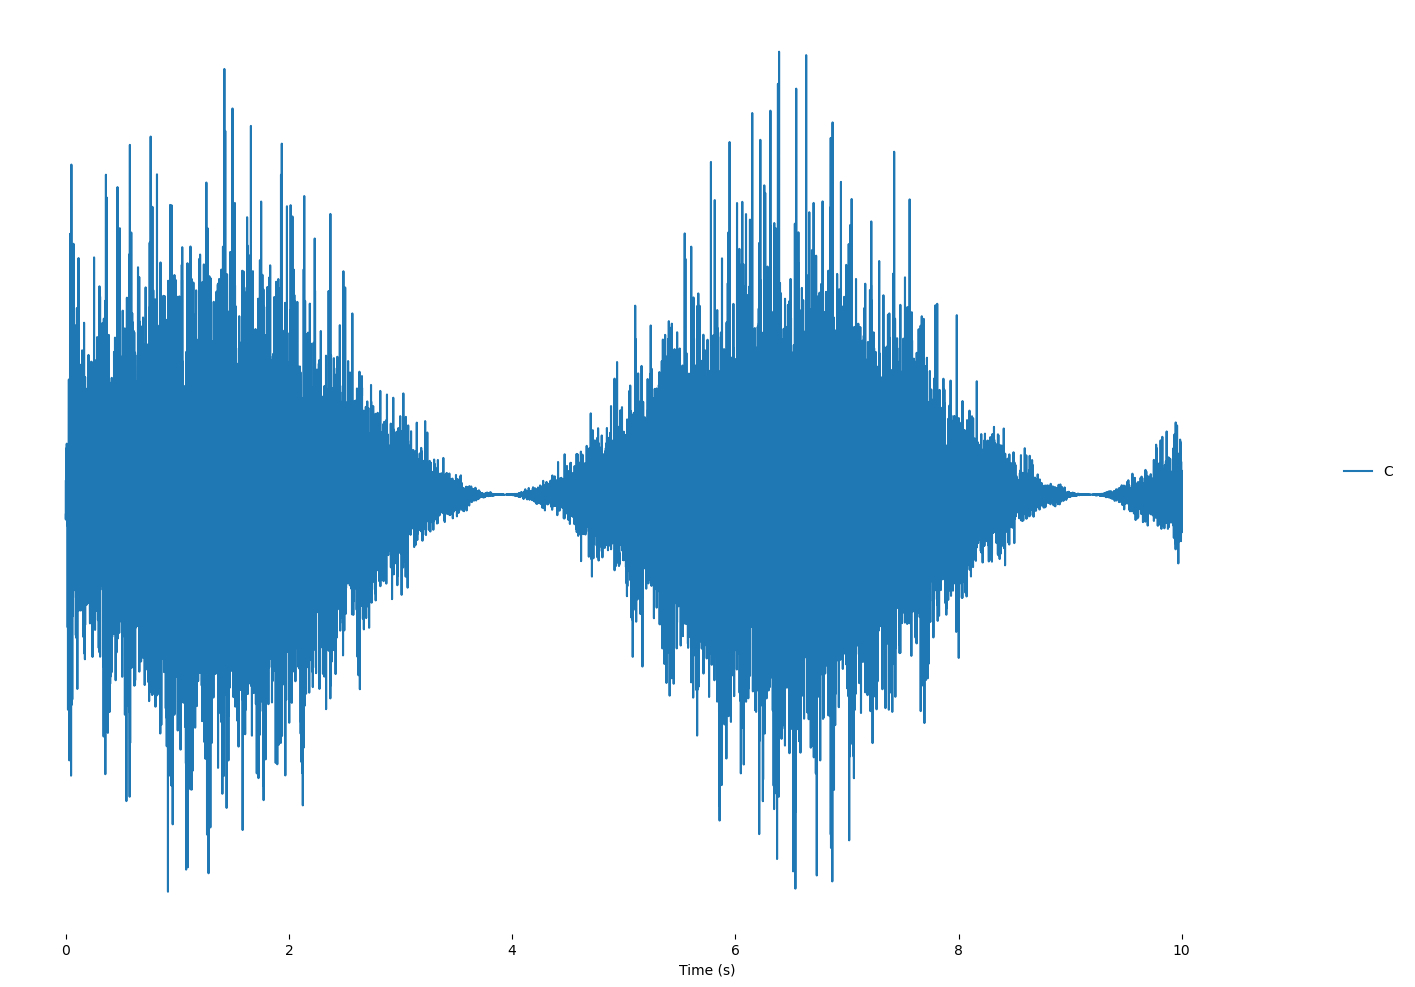

Text(0.5, 0, 'x')

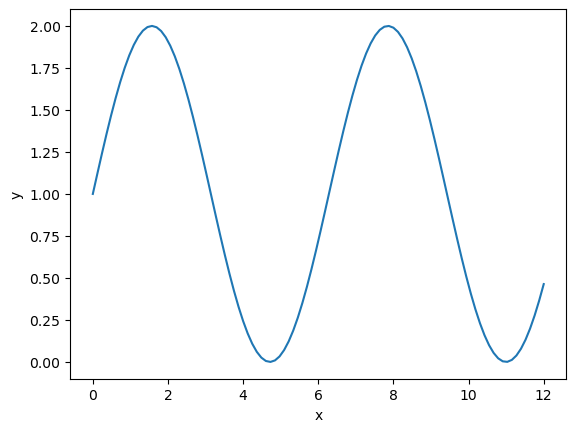

In [90]:
# pick a soundfont to use
system = "mono"

generator = copy.copy(guitar_sampler)
#generator = flute_sampler
#generator.modify_preset({'filter':'on'})
#generator.modify_preset({'looping':'forwardback',
 #                        'loop_start': 0.5, 'loop_end': 0.7}) #
generator.load_preset('sustain')

# we use a 'chord' here to create more harmonic richness (stacking fifths)...
notes = [["B2"]]
score =  Score(notes, 10)

data = {'pitch': 0.,
        'time_evo': x,
        'pitch_shift': y,
     #   'cutoff': y,
        'volume':y}

mlims = {'time_evo':[0,12],
         'pitch_shift': [0,2],
    #     'cutoff': [0,2],
         'volume': [0,2]}

plims = {'pitch_shift': [0,24]}

# set up source
sources = Objects(data.keys())
sources.fromdict(data)
sources.apply_mapping_functions(map_lims=mlims, param_lims=plims)

soni = Sonification(score, sources, generator, system)
soni.render()
dobj = soni.notebook_display(show_waveform=1);
plt.plot(x,y)
plt.ylabel('y')
plt.xlabel('x')

In [130]:
sonifier = phonon_dos_sonifier.PhononDOSSonifier("mp-3953",temperatures=[300])
freq_list = []
integrated_dos_list = []

site_names = ['Ca_1', 'Ca_2', 'C_1', 'C_2', 'O_1', 'O_2', 'O_3', 'O_4', 'O_5', 'O_6']
temperature = 300

for site_name in site_names:
    # Get site data
    if site_name not in sonifier.dos_dict['projection']:
        available = list(sonifier.dos_dict['projection'].keys())
        raise ValueError(f"Site '{site_name}' not found. Available: {available}")
    
    site_data = sonifier.dos_dict['projection'][site_name]
    frequencies_hz = site_data['frequencies']
    densities = site_data['densities']
    
    # Get stats
    if temperature is not None:
        if 'thermal' not in site_data['stats']:
            raise ValueError("No thermal data")
        if str(temperature) not in site_data['stats']['thermal']:
            raise ValueError(f"Temperature {temperature}K not found")
        stats = site_data['stats']['thermal'][str(temperature)]
        temp_label = f"{int(temperature)}K"
    else:
        stats = site_data['stats']['athermal']
        temp_label = "athermal"
    
    band_centre_hz = stats['band_centre']
    q25_hz = stats['quantile_25']
    q75_hz = stats['quantile_75']
    iqr_hz = stats['IQR']
    integrated_dos = stats['integrated_dos']
    
    
    print(f"\nSonifying: {site_name} ({temp_label})")
    print(f"  Band centre: {band_centre_hz:.2e} Hz")
    print(f"  IQR: {iqr_hz:.2e} Hz")
    freq_list.append(int(band_centre_hz))
    integrated_dos_list.append(int(integrated_dos))

print([f"{freq:.2e}" for freq in freq_list])

Fetching phonon DOS data for mp-3953...
There are 3 imaginary frequencies which have not been processed
  Phonon range (all sites): 1.76e+10 - 5.53e+13 Hz

Sonifying: Ca_1 (300K)
  Band centre: 4.52e+12 Hz
  IQR: 3.67e+12 Hz

Sonifying: Ca_2 (300K)
  Band centre: 4.53e+12 Hz
  IQR: 3.58e+12 Hz

Sonifying: C_1 (300K)
  Band centre: 4.89e+12 Hz
  IQR: 2.79e+12 Hz

Sonifying: C_2 (300K)
  Band centre: 4.89e+12 Hz
  IQR: 2.79e+12 Hz

Sonifying: O_1 (300K)
  Band centre: 4.73e+12 Hz
  IQR: 2.90e+12 Hz

Sonifying: O_2 (300K)
  Band centre: 4.55e+12 Hz
  IQR: 3.04e+12 Hz

Sonifying: O_3 (300K)
  Band centre: 4.69e+12 Hz
  IQR: 2.70e+12 Hz

Sonifying: O_4 (300K)
  Band centre: 4.73e+12 Hz
  IQR: 2.90e+12 Hz

Sonifying: O_5 (300K)
  Band centre: 4.55e+12 Hz
  IQR: 3.04e+12 Hz

Sonifying: O_6 (300K)
  Band centre: 4.69e+12 Hz
  IQR: 2.70e+12 Hz
['4.52e+12', '4.53e+12', '4.89e+12', '4.89e+12', '4.73e+12', '4.55e+12', '4.69e+12', '4.73e+12', '4.55e+12', '4.69e+12']


In [133]:
print([f"{freq:.2e}" for freq in integrated_dos_list],"/n")

['2.44e+12', '2.43e+12', '5.98e+11', '5.98e+11', '1.56e+12', '1.63e+12', '1.57e+12', '1.56e+12', '1.63e+12', '1.57e+12'] /n


In [136]:
system = "mono"

generator = copy.copy(wav_sampler)

generator.modify_preset({'note_length':5,
                         'volume_envelope': {'use':'off',
                    # A,D,R values in seconds, S sustain fraction from 0-1 that note
                    # will 'decay' to (after time A+D)
                    'A':0.1,    # ✏️ Time to fade in note to maximum volume, using 10 ms
                    'D':0.0,    # ✏️ Time to fall from maximum volume to sustained level (s), irrelevant while S is 1 
                    'S':1.,      # ✏️ fraction of maximum volume to sustain note at while held, 1 implies 100% 
                    'R':.2}}) # ✏️ Time to fade out once note is released, using 100 ms

notes = [["G2","A2","A#2","B2","C3","C#3","D3","D#3","E3","F3","F#3","G3","G#3","A3","A3","B3","C4","C#4","D4","D#4","E4","F4","F#4","G4","G#4","A4","A#4","B4","C5"]]
         #["A2","A#2","B2","C3","C#3","D3","D#3","E3","F3","F#3","G3","G#3","A3","A3","B3","C4","C#4","D4","D#4","E4","F4","F#4","G4","G#4","A4","A#4","B4","C5"]]
score =  Score(notes, 6,pitch_binning="uniform")

soni_list = []

for pitch,amplitude in zip(freq_list,integrated_dos_list):

    print(pitch,amplitude)

    maps = {'pitch': pitch,
            'time': [0]}
    
    lims = {'time': [0,6],
            'pitch': [4.5E12,5E12]}
    
    # volume from multiple put together
    
    # set up source
    sources = Objects(maps.keys())
    sources.fromdict(maps)
    sources.apply_mapping_functions(map_lims=lims)
    
    soni = Sonification(score, sources, generator, system)
    soni_list.append(soni)


4519566724560 2439567457217
4529721983676 2434280543144
4888758626704 597701394294
4888758626704 597701394294
4731163154697 1557600008976
4545241717891 1631192444326
4692056336181 1572253432432
4731163154697 1557600008976
4545241717891 1631192444326
4692056336181 1572253432432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.81it/s]


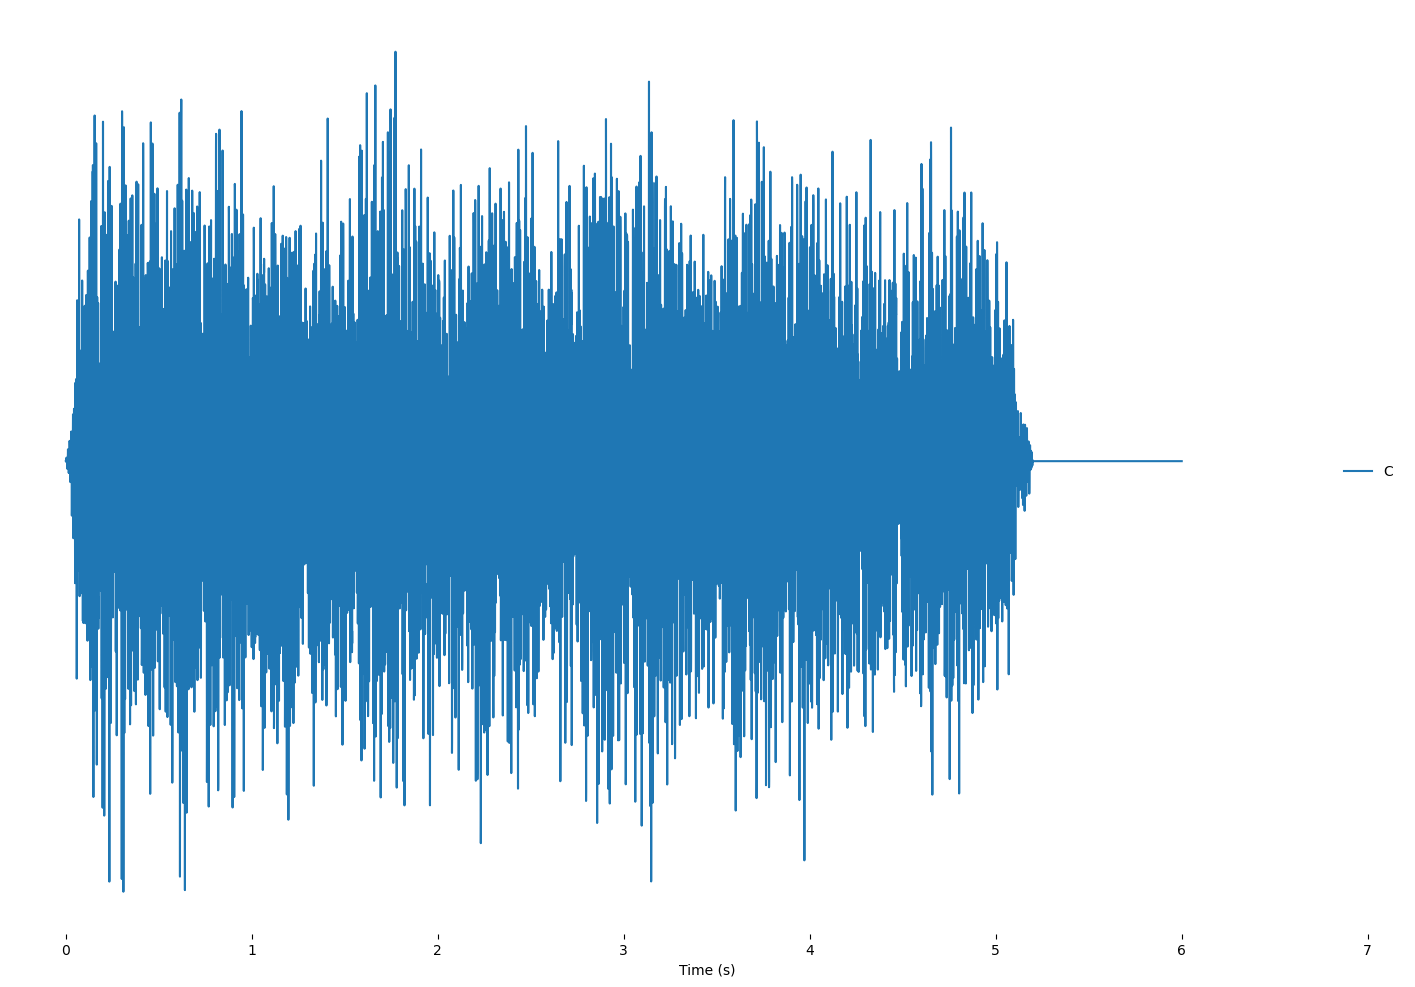

In [137]:
for i in range(1,len(soni_list)):
            soni_list[i-1].render()
            soni_list[i].out_channels = soni_list[i-1].out_channels

joint_soni = soni_list[-1]
joint_soni.render()
dobj = soni.notebook_display(show_waveform=1)

In [ ]:
system = "mono"

generator = copy.copy(wav_sampler)
generator.modify_preset({'note_length':1})

notes = [["G2","G#2","A2","A#2","B2","C3","C#3","D3","D#3","E3","F3","F#3","G3","G#3","A3","A3","B3","C4","C#4","D4","D#4","E4","F4","F#4","G4","G#4","A4","A#4","B4","C5"]]
score =  Score(notes, 5)

data = {'pitch': [1.1,1.1,1.1,0.1],
        'time': [0,1,2,3]}

mlims = {'time': [0,5],
        'pitch': [0,2]}

plims = {'pitch': [0,36]}

# set up source
sources = Events(data.keys())
sources.fromdict(data)
sources.apply_mapping_functions(map_lims=mlims, param_lims = plims)

soni = Sonification(score, sources, generator, system)
soni.render()
dobj = soni.notebook_display(show_waveform=1);

In [122]:
system = "mono"

generator = copy.copy(wav_sampler)

generator.modify_preset({'note_length':5,
                         'volume_envelope': {'use':'off',
                    # A,D,R values in seconds, S sustain fraction from 0-1 that note
                    # will 'decay' to (after time A+D)
                    'A':0.1,    # ✏️ Time to fade in note to maximum volume, using 10 ms
                    'D':0.0,    # ✏️ Time to fall from maximum volume to sustained level (s), irrelevant while S is 1 
                    'S':1.,      # ✏️ fraction of maximum volume to sustain note at while held, 1 implies 100% 
                    'R':.2}}) # ✏️ Time to fade out once note is released, using 100 ms

notes = [["G2","A2","A#2","B2","C3","C#3","D3","D#3","E3","F3","F#3","G3","G#3","A3","A3","B3","C4","C#4","D4","D#4","E4","F4","F#4","G4","G#4","A4","A#4","B4","C5"]]
         #["A2","A#2","B2","C3","C#3","D3","D#3","E3","F3","F#3","G3","G#3","A3","A3","B3","C4","C#4","D4","D#4","E4","F4","F#4","G4","G#4","A4","A#4","B4","C5"]]
score =  Score(notes, 6,pitch_binning="uniform")

soni_list = []

for pitch,amplitude in zip(freq_list,integrated_dos_list):

    print(pitch,amplitude)

    maps = {'pitch': pitch,
            'time_evo': [0,1,2,3,4,5],
            'cutoff': [0,1,0,1,0,1],
            'volume': amplitude}
    
    lims = {'time': [0,6],
            'pitch': [1.5E12,2.5E12],
            'volume':[2.3E12,2.9E12]}
    
    # volume from multiple put together
    
    # set up source
    sources = Objects(maps.keys())
    sources.fromdict(maps)
    sources.apply_mapping_functions(map_lims=lims)
    
    soni = Sonification(score, sources, generator, system)
    soni_list.append(soni)

2120769407761 2761690513055
2120769407761 2761690513055
1628662442582 2854079139249
2193134764147 2382597494075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


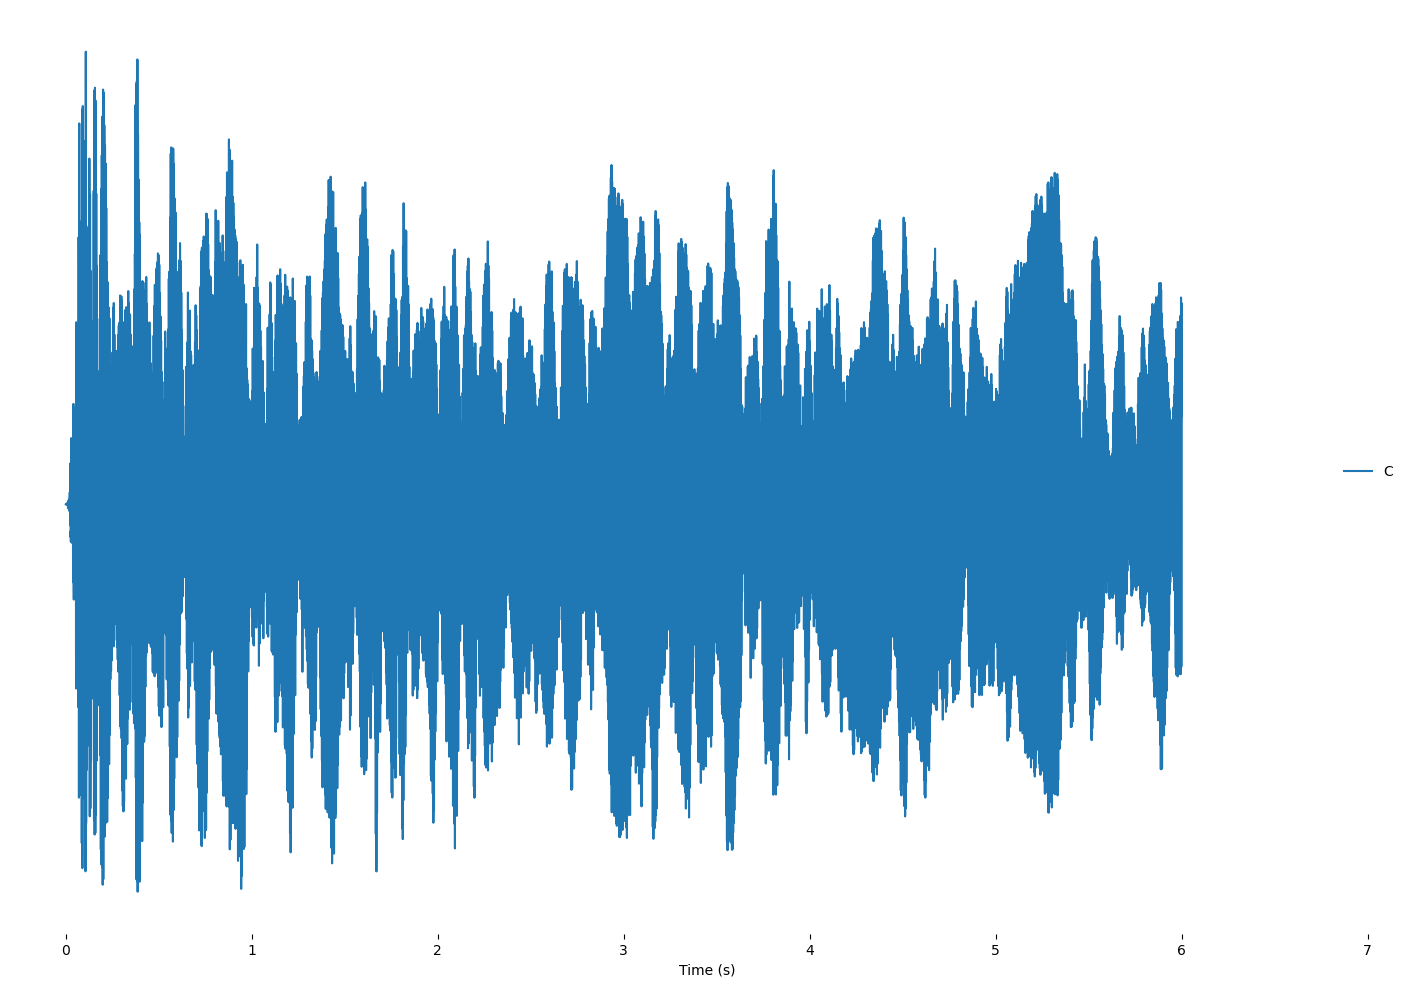

In [123]:
soni_list[0].render()
dobj = soni_list[0].notebook_display(show_waveform=1);